In [1]:
import numpy as np
from scipy.io import arff
import pandas as pd
from sklearn.metrics import mean_squared_error
from keras.optimizers import RMSprop, SGD,Adam
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler


Using TensorFlow backend.


In [2]:
data = arff.loadarff('dataold/x_features.arff')
df = pd.DataFrame(data[0])

df.head()
data_val = arff.loadarff('dbpsb-K25/xval_features.arff')
df_val = pd.DataFrame(data_val[0])
data_test = arff.loadarff('dbpsb-K25/xtest_features.arff')
df_test = pd.DataFrame(data_test[0])

In [3]:
df.describe()

,triple,bgp,join,leftjoin,union,filter,project,distinct,treesize,pcs0,...,pcs16,pcs17,pcs18,pcs19,pcs20,pcs21,pcs22,pcs23,pcs24,ex_time
count,1.260000e+03,1.260000e+03,1.260000e+03,1.260000e+03,1.260000e+03,1.260000e+03,1.260000e+03,1.260000e+03,1.260000e+03,1.260000e+03,...,1.260000e+03,1.260000e+03,1.260000e+03,1.260000e+03,1.260000e+03,1.260000e+03,1.260000e+03,1.260000e+03,1.260000e+03,1260.000000
mean,9.523810e-08,-9.523810e-08,-2.857143e-07,9.523810e-08,-4.761905e-08,-3.333333e-07,-2.857143e-07,-2.857143e-07,9.523810e-08,-6.190476e-08,...,3.158730e-07,-1.611111e-07,-4.047619e-08,1.127846e-17,-5.873016e-08,1.023810e-07,-1.944444e-07,-7.142857e-09,-9.920635e-08,885.633492
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.999999e-01,1.000000e+00,1.000000e+00,1.000000e+00,9.999999e-01,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.999999e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2490.144158
min,-1.288789e+00,-6.987850e-01,-3.060650e-01,-4.574470e-01,-7.879280e-01,-7.894410e-01,-2.448518e+00,-8.656820e-01,-1.497571e+00,-1.138083e+00,...,-5.842450e-01,-3.422530e-01,-4.707850e-01,-1.081591e+00,-8.824750e-01,-1.038105e+00,-7.560700e-01,-2.573500e-01,-9.406970e-01,0.200000
25%,-5.948250e-01,-6.987850e-01,-3.060650e-01,-4.574470e-01,-7.879280e-01,-7.894410e-01,4.080860e-01,-8.656820e-01,-5.587950e-01,-7.322850e-01,...,-2.498490e-01,-2.323570e-01,-2.603270e-01,-7.087300e-01,-3.148710e-01,-4.359040e-01,-2.482230e-01,-2.388870e-01,-2.592940e-01,1.000000
50%,-2.478440e-01,-2.911600e-01,-3.060650e-01,-4.574470e-01,-7.879280e-01,-7.894410e-01,4.080860e-01,-8.656820e-01,-8.940700e-02,-3.051300e-01,...,-2.052630e-01,-2.323570e-01,-2.256630e-01,-3.489530e-01,-1.296530e-01,-1.256790e-01,-1.749760e-01,-2.287620e-01,-1.661110e-01,19.800000
75%,9.913800e-02,1.164640e-01,-3.060650e-01,2.287200e-02,4.848790e-01,7.176730e-01,4.080860e-01,1.154242e+00,-8.940700e-02,3.612330e-01,...,-2.052630e-01,-1.803000e-01,-1.866660e-01,1.547360e-01,-6.174000e-03,2.288640e-01,-8.952100e-02,-2.064170e-01,-5.739700e-02,174.800000
max,2.528008e+00,2.562210e+00,3.978841e+00,3.385109e+00,1.757685e+00,2.224787e+00,4.080860e-01,1.154242e+00,3.196308e+00,3.026684e+00,...,4.431685e+00,4.465737e+00,4.453949e+00,3.176867e+00,4.315582e+00,4.217470e+00,5.465061e+00,4.469256e+00,7.009005e+00,34397.000000


In [4]:
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import Dense,Lambda, BatchNormalization
from keras.optimizers import SGD, Adagrad, Adam
from sklearn.utils import shuffle

#suffle
df = shuffle(df)
df.reset_index(inplace=True, drop=True) 

df_val = shuffle(df_val)
df_val.reset_index(inplace=True, drop=True)

df_test = shuffle(df_test)
df_test.reset_index(inplace=True, drop=True)

#Eliminando > 30000
x_train = df.loc[:, df.columns != 'ex_time'].values
y_train = df[['ex_time']].values
#x_train = x_train[y_train[:,0]<30000,:]
#y_train = y_train[y_train[:,0]<30000,:]



x_val = df_val.loc[:, df_val.columns != 'ex_time'].values
y_val = df_val[['ex_time']].values

x_test = df_test.loc[:, df_test.columns != 'ex_time'].values
y_test = df_test[['ex_time']].values

y_val_log = np.log(y_val)
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)


y_train_log_min = np.min(y_train_log)
y_train_min = np.min(y_train)

y_train_log_max = np.max(y_train_log)
y_train_max = np.max(y_train)

print(y_train_log_min,y_train_min)
print(y_train_log_max,y_train_max)


-1.6094379124341003 0.2
10.445724630256212 34397.0


In [5]:
np.unique(x_train,axis=0).shape

(60, 34)

In [5]:
#Standarización del target

scaler = StandardScaler()
y_train_log_std = scaler.fit_transform(y_train_log)
y_val_log_std = scaler.transform(y_val_log)
y_test_log_std = scaler.transform(y_test_log)

In [9]:
x_train.shape

(1260, 34)

In [1]:
plt.hist(y_train_log_std)
plt.hist(y_val_log_std)
plt.hist(y_test_log_std)


NameError: name 'plt' is not defined

In [7]:
#LINEAR
from keras import backend as K

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def rmse(y_true, y_pred):
    return K.exp(K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)))

In [ ]:
from keras.optimizers import RMSprop, SGD,Adam
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.layers import Input


# Set callback functions to early stop training and save the best model so far
callbacks_best = [
    EarlyStopping(monitor='val_loss', patience=20),
    #ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)
]
l1 = range(80,100,5)
l2 = range(5,180,20)
l3 = range(5,180,20)

best_l1 = 1
best_l2 = 1
best_l3 = 1

max_r2=0
min_rmse=10000
for l1current in l1:
    for l2current in l2:
        for l3current in l3:
            optimizer = SGD(lr=0.001)
            model = Sequential()
            model.add(Dense(l1current, input_shape=(34,), activation='relu'))
            model.add(Dense(l2current, activation='relu'))
            model.add(Dense(l3current,activation='relu'))
            model.add(Dense(1, activation='linear'))
            model.compile(loss='mse', optimizer=optimizer, metrics=['mse','mae',coeff_determination,rmse])
            history = model.fit(x_train, y_train_log_std,
                    epochs=150,
                    verbose=0,
                   # batch_size=20,
                    validation_data=(x_val, y_val_log_std),
                    callbacks=callbacks_best
                       )

            y_pred_val = np.exp(scaler.inverse_transform(model.predict(x_val).reshape(-1, 1)))
            y_pred_train = np.exp(scaler.inverse_transform(model.predict(x_train).reshape(-1, 1)))
            y_pred_test = np.exp(scaler.inverse_transform(model.predict(x_test).reshape(-1, 1)))
            
            
            
            current_rmse = np.sqrt(mean_squared_error(y_pred_val,y_val))
            if current_rmse < min_rmse:
                best_l1 = l1current
                best_l2 = l2current
                best_l3 = l3current

                min_rmse = current_rmse
                print("RMSE Train", np.sqrt(mean_squared_error(y_pred_train, y_train)))
                print("RMSE VAL", np.sqrt(mean_squared_error(y_pred_val, y_val)))
                print("RMSE TEST", np.sqrt(mean_squared_error(y_pred_test, y_test)))
                model.save('modelos/my_model_{}_{}_{}.h5'.format(best_l1,best_l2,best_l3))
model.summary()


RMSE Train 1278.082253548722
RMSE VAL 534.1207781968828
RMSE TEST 268.5038246743144
RMSE Train 1277.2717580854162
RMSE VAL 524.43190513332
RMSE TEST 256.03972471527453
RMSE Train 1275.2856539615004
RMSE VAL 522.270185714763
RMSE TEST 252.9377498172899
RMSE Train 1277.030034813514
RMSE VAL 520.9440909852551
RMSE TEST 260.822346331414
RMSE Train 1275.4945830137194
RMSE VAL 515.9978865140205
RMSE TEST 249.44524561031662
RMSE Train 1274.5466109401757
RMSE VAL 511.73402574207495
RMSE TEST 247.27909829464076


In [10]:
print("Best RMSE {} Best enurons in L1: {},  Best neuron in L2: {}".format(min_rmse,best_l1,best_l2))

Best RMSE 558.0388418430931 Best enurons in L1: 80,  Best neuron in L2: 80


In [13]:
from keras.models import Model
from keras.layers import Input

input_data = Input(shape=(34,))
encoded = Dense(20, activation='sigmoid')(input_data)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(input=input_data, output=decoded)
encoder = Model(input=input_data, output=encoded)
encoded_input = Input(shape=(34,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))

decoded = decoder.predict(x_train)
decoded.shape

/home/daniel/.conda/envs/rhassan/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys
/home/daniel/.conda/envs/rhassan/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


ValueError: Input 0 is incompatible with layer dense_6: expected axis -1 of input shape to have value 20 but got shape (None, 34)

W0904 14:48:14.092521 139940250486592 deprecation.py:506] From /home/daniel/.conda/envs/rhassan/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train on 1260 samples, validate on 420 samples
Epoch 1/150
1260/1260 [==============================] - 1s 558us/step - loss: 0.9355 - mean_squared_error: 0.9355 - mean_absolute_error: 0.7758 - coeff_determination: 0.0142 - rmse: 2.5875 - val_loss: 0.7808 - val_mean_squared_error: 0.7808 - val_mean_absolute_error: 0.7070 - val_coeff_determination: 0.1781 - val_rmse: 2.3358
Epoch 2/150
1260/1260 [==============================] - 0s 126us/step - loss: 0.7766 - mean_squared_error: 0.7766 - mean_absolute_error: 0.7085 - coeff_determination: 0.1853 - rmse: 2.3490 - val_loss: 0.6472 - val_mean_squared_error: 0.6472 - val_mean_absolute_error: 0.6457 - val_coeff_determination: 0.3197 - val_rmse: 2.1441
Epoch 3/150
1260/1260 [==============================] - 0s 128us/step - loss: 0.6707 - mean_squared_error: 0.6707 - mean_absolute_error: 0.6598 - coeff_determination: 0.2990 - rmse: 2.1979 - val_loss: 0.5476 - val_mean_squared_error: 0.5476 - val_mean_absolute_error: 0.5946 - val_coeff_determi

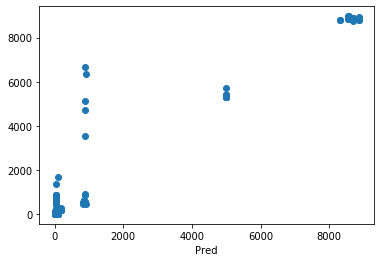

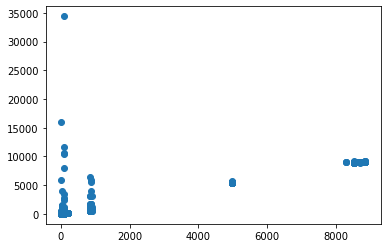

In [22]:
# Set callback functions to early stop training and save the best model so far
callbacks_best = [EarlyStopping(monitor='val_loss', patience=50),
         #ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)
            ]
optimizer = SGD(lr=0.001)
#optimizer = Adagrad(lr=0.005)
#optimizer = RMSprop(0.001) 
#optimizer = 'adam'
model = Sequential()
model.add(Dense(90, input_shape=(34,), activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer=optimizer, metrics=['mse','mae',coeff_determination,rmse])
history = model.fit(x_train, y_train_log_std,
                epochs=150,
               # batch_size=20,
                validation_data=(x_val, y_val_log_std),
                callbacks=callbacks_best
                   )

y_pred_val = np.exp(scaler.inverse_transform(model.predict(x_val).reshape(-1, 1)))
y_pred_train = np.exp(scaler.inverse_transform(model.predict(x_train).reshape(-1, 1)))
y_pred_test = np.exp(scaler.inverse_transform(model.predict(x_test).reshape(-1, 1)))

print("RMSE Train", np.sqrt(mean_squared_error(y_pred_train, y_train)))
print("RMSE VAL", np.sqrt(mean_squared_error(y_pred_val, y_val)))
print("RMSE TEST", np.sqrt(mean_squared_error(y_pred_test, y_test)))

plt.scatter(y_pred_val,y_val)
plt.xlabel("Pred")
plt.show()
plt.scatter(y_pred_train,y_train)
plt.show()


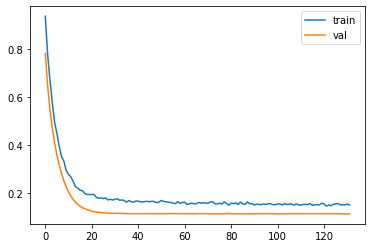

In [23]:
plt.plot(history.history['loss'],label="train")
plt.plot(history.history['val_loss'],label="val")
plt.legend()

In [33]:
y_pred_val_log = model.predict(x_val)
y_pred_train_log =model.predict(x_train)
y_pred_test_log =model.predict(x_test)
print("RMSE Train",np.sqrt(mean_squared_error(y_pred_train_log,y_train_log)))

print("RMSE VAL",np.sqrt(mean_squared_error(y_pred_val_log,y_val_log)))
print("RMSE TEST",np.sqrt(mean_squared_error(y_pred_test_log,y_test_log)))

RMSE Train 1.0500887165434236
RMSE VAL 1.0071129066903037
RMSE TEST 1.0471842002327723


In [13]:
model.save('modelos/best_model_without_early_stop.h5'.format(best_l1,best_l2))

In [45]:
def coeff_determination_simple(y_true, y_pred):
    SS_res =  np.sum(np.square( y_true - y_pred )) 
    SS_tot = np.sum(np.square( y_true - np.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )
print(coeff_determination_simple(y_pred_train,y_train))
print(coeff_determination_simple(y_pred_val,y_val))
print(coeff_determination_simple(y_pred_test,y_test))

0.6600985653773364
0.9415134266340286
0.9857207026672177


In [21]:
for i in range(y_val.shape[0]):
    print("%10.3f,  %10.3f"%(y_pred_val[i,0],y_val[i,0]))
for i in range(y_pred_train.shape[0]):
    print("%10.3f,  %10.3f"%(y_pred_train[i,0],y_train[i,0]))

  5421.363,    5345.800
     1.355,       1.000
     1.001,       1.000
   798.395,     522.200
     4.207,     120.600
    51.573,     827.000
    47.498,       2.000
    20.508,      19.000
     4.207,       3.000
    51.573,     707.400
    21.764,      19.000
     1.012,       1.000
    51.573,      93.600
     1.001,       1.000
  5421.363,    5353.600
     1.355,       1.000
  9402.736,    8770.400
    51.573,    1337.000
     1.015,       1.000
     1.353,       1.000
    51.573,      22.400
    43.292,      79.600
   184.612,     171.400
    20.400,      19.200
     8.786,      67.600
     1.001,       1.000
     1.353,       1.000
     1.001,       1.000
   104.406,      19.600
     8.786,       1.000
   176.878,     170.000
     1.001,       1.000
     1.355,       1.000
     1.001,       1.000
    47.498,      48.200
     1.355,       1.000
     1.001,       1.000
     1.001,       1.000
    20.400,      19.200
  9224.926,    8807.400
     2.520,      13.000
  9402.736,    8

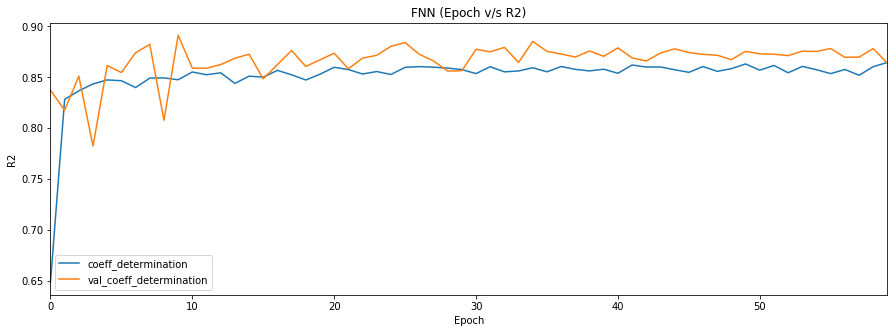

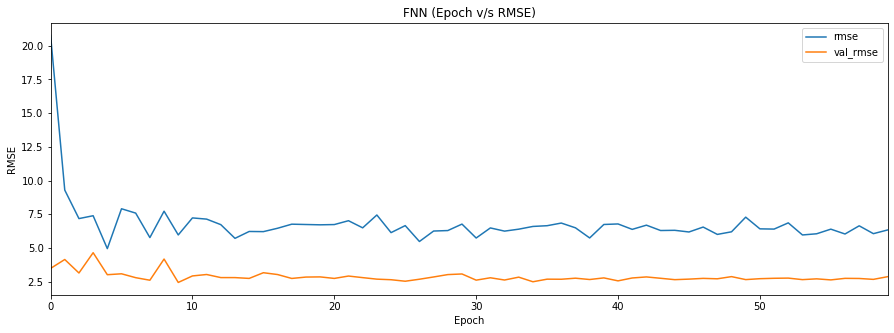

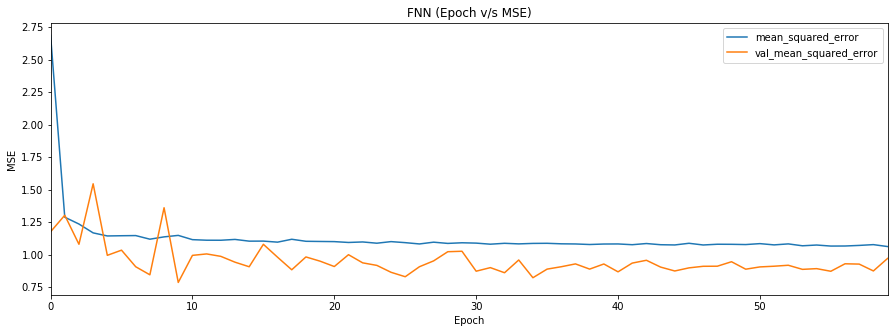

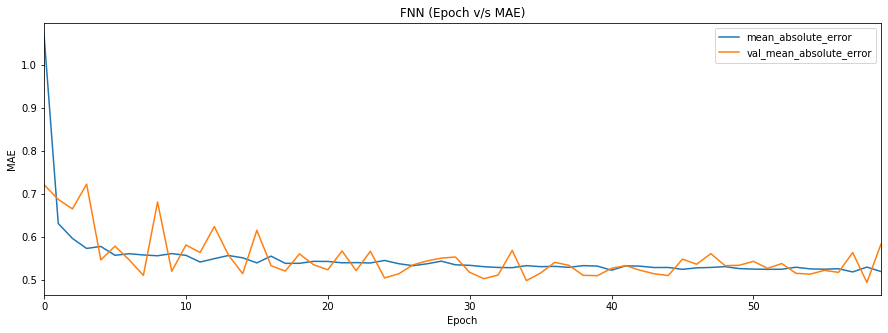

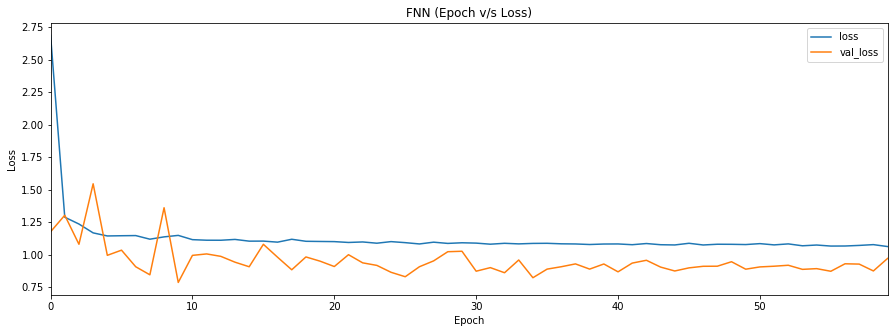

In [31]:
def plot_history(history, title=''):
    plot_r2 = {'coeff_determination': history.history['coeff_determination'], 'val_coeff_determination': history.history['val_coeff_determination']}
    plot_rmse = {'rmse': history.history['rmse'], 'val_rmse': history.history['val_rmse']}
    plot_mse = {'mean_squared_error': history.history['mean_squared_error'], 'val_mean_squared_error': history.history['val_mean_squared_error']}
    plot_mae = {'mean_absolute_error': history.history['mean_absolute_error'], 'val_mean_absolute_error': history.history['val_mean_absolute_error']}
    plot_loss = {'loss': history.history['loss'], 'val_loss': history.history['val_loss']}

    _ = pd.DataFrame(plot_r2).plot(figsize=(15, 5), title='{0} (Epoch v/s R2)'.format(title))
    _.set_xlabel("Epoch")
    _.set_ylabel("R2")
   
    _ = pd.DataFrame(plot_rmse).plot(figsize=(15, 5), title='{0} (Epoch v/s RMSE)'.format(title))
    _.set_xlabel("Epoch")
    _.set_ylabel("RMSE")
    
    _ = pd.DataFrame(plot_mse).plot(figsize=(15, 5), title='{0} (Epoch v/s MSE)'.format(title))
    _.set_xlabel("Epoch")
    _.set_ylabel("MSE")
    
    _ = pd.DataFrame(plot_mae).plot(figsize=(15, 5), title='{0} (Epoch v/s MAE)'.format(title))
    _.set_xlabel("Epoch")
    _.set_ylabel("MAE")

    _ = pd.DataFrame(plot_loss).plot(figsize=(15, 5), title='{0} (Epoch v/s Loss)'.format(title))
    _.set_xlabel("Epoch")
    _.set_ylabel("Loss")
#     
plot_history(history, title='FNN')

<div style="background-color:rgb(174, 229, 202);">

**Se probará con datos en escala lineal, escalando los targets entre 0 y 1 para los Sigmoide de salida**

In [51]:
from sklearn.preprocessing import MinMaxScaler

#scale targets
mms = MinMaxScaler()
mms.fit(y_train)
y_train_norm = mms.transform(y_train)
y_val_norm = mms.transform(y_val)
y_test_norm = mms.transform(y_test)


# Set callback functions to early stop training and save the best model so far
callbacks_best = [EarlyStopping(monitor='val_loss', patience=50),
         #ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)
            ]
#optimizer = SGD(lr=0.001)
#optimizer = RMSprop(0.001) 
optimizer = 'adam'
model = Sequential()
model.add(Dense(400, activation='relu',kernel_initializer='he_uniform', input_shape=(34,)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(400, activation='relu',kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(400, activation='relu',kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#model.add(Dense(200, activation='sigmoid'))
#model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mse', optimizer=optimizer, metrics=['mse','mae',coeff_determination,rmse])
history = model.fit(x_train, y_train_norm, epochs=200, validation_data=(x_val, y_val_norm),
             callbacks=callbacks_best
                   )
model.save('modelos/best_model_with_early_stop.h5'.format(best_l1,best_l2))



Train on 1260 samples, validate on 420 samples
Epoch 1/200
1260/1260 [==============================] - 6s 5ms/step - loss: 0.2483 - mean_squared_error: 0.2483 - mean_absolute_error: 0.3871 - coeff_determination: -130.3951 - rmse: 1.5502 - val_loss: 0.1174 - val_mean_squared_error: 0.1174 - val_mean_absolute_error: 0.2117 - val_coeff_determination: -36.1442 - val_rmse: 1.2901
Epoch 2/200
1260/1260 [==============================] - 1s 850us/step - loss: 0.1508 - mean_squared_error: 0.1508 - mean_absolute_error: 0.2789 - coeff_determination: -62.1765 - rmse: 1.3755 - val_loss: 0.0532 - val_mean_squared_error: 0.0532 - val_mean_absolute_error: 0.1735 - val_coeff_determination: -15.9874 - val_rmse: 1.2052
Epoch 3/200
1260/1260 [==============================] - 1s 769us/step - loss: 0.0747 - mean_squared_error: 0.0747 - mean_absolute_error: 0.1854 - coeff_determination: -51.8116 - rmse: 1.2309 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.1146 - val_coef

0.00030636787 0.23332718 0.0 0.260762629081775
0.00030636787 0.23332718 0.0 1.0
10.738075 8025.908 0.2 8969.6
RMSE Train 1261.500971119792 R2 0.7431550602086896
RMSE VAL 560.1049195781934 R2 0.9352291983797915
RMSE TEST 341.6038119179122 R2 0.9749757308516355


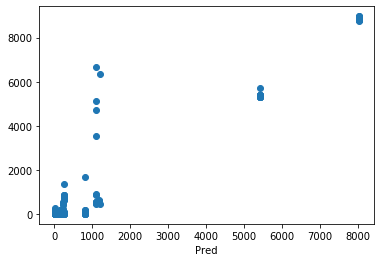

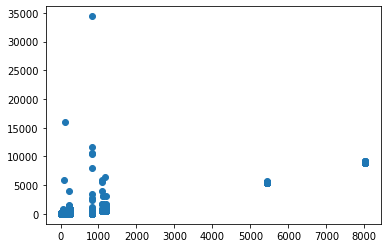

In [53]:
#Predicciones
y_pred_val_norm = model.predict(x_val)
y_pred_train_norm =model.predict(x_train)
y_pred_train_inversed = mms.inverse_transform(y_pred_train_norm.reshape(-1, 1))

print(np.min(y_pred_val_norm),np.max(y_pred_val_norm),np.min(y_val_norm),np.max(y_val_norm))
print(np.min(y_pred_train_norm),np.max(y_pred_train_norm),np.min(y_train_norm),np.max(y_train_norm))

y_pred_val_inversed = mms.inverse_transform(y_pred_val_norm.reshape(-1, 1))
print(np.min(y_pred_val_inversed),np.max(y_pred_val_inversed),np.min(y_val),np.max(y_val))


y_pred_test_norm =model.predict(x_test)
y_pred_test_inversed = mms.inverse_transform(y_pred_test_norm.reshape(-1, 1))

print("RMSE Train",np.sqrt(
    mean_squared_error(
        y_pred_train_inversed,
        y_train)),
      "R2",coeff_determination_simple(y_train,
                                      y_pred_train_inversed))
print("RMSE VAL",np.sqrt(mean_squared_error(y_pred_val_inversed,y_val)),"R2",coeff_determination_simple(y_val,
                                      y_pred_val_inversed))
print("RMSE TEST",np.sqrt(mean_squared_error(y_pred_test_inversed,y_test)),"R2",coeff_determination_simple(y_test,
                                      y_pred_test_inversed))

plt.scatter(y_pred_val_inversed,y_val)
plt.xlabel("Pred")
plt.show()
plt.scatter(y_pred_train_inversed, y_train)
plt.show()

In [41]:
plot_history(history, title='FNN')

KeyError: 'mean_squared_error'

In [40]:
for i in range(y_val.shape[0]):
    print("%10.3f,  %10.3f"%(y_pred_val_inversed[i,0],y_val[i,0]))
for i in range(y_pred_train_inversed.shape[0]):
    print("%10.3f,  %10.3f"%(y_pred_train_inversed[i,0],y_train[i,0]))

   166.572,     179.600
  1350.625,      53.400
    56.209,       0.200
   119.110,       1.000
    93.444,       2.000
   173.004,      80.800
   173.489,      34.600
   129.793,      19.000
   180.124,      50.600
   264.786,      24.800
   105.893,      19.200
  7743.977,    8807.400
   264.786,      14.000
   110.180,      19.200
  1350.625,       6.000
  7742.298,    8815.800
   168.177,       1.000
    56.104,       1.000
  7716.535,    8878.600
   175.323,      85.000
   264.786,     870.600
    56.209,       1.000
    56.104,       1.000
   229.844,      29.400
    78.853,       1.000
    91.536,      25.600
   166.572,     173.400
   166.572,     176.200
    78.853,       1.000
  4846.250,    5325.400
   229.844,      22.800
    62.791,       1.000
   220.892,     170.000
  7743.977,    8868.200
    78.853,       1.000
   166.572,     175.000
   119.110,       1.000
   229.844,     109.400
   107.076,      21.000
  1350.625,     196.000
  1059.565,     590.400
   229.844,     

<div style="background-color:rgb(174, 229, 202);">

**SVR del paper original**

In [19]:
Cs, epsilons = pd.np.meshgrid([i for i in range(1,1000,50)],np.arange(0.05,0.3,0.05))
scores_train = []
scores_val = []
mse_svr = []
mse_svr_val = []
best_epsilon = 0.05
best_c = 1
best_mse_val_svr = -1 
scaler_yz = StandardScaler()
scaler_yz = scaler_yz.fit(y_train)
y_train_scaled_svr = scaler_yz.transform(y_train)
y_val_scaled_svr = scaler_yz.transform(y_val)

for C, epsilon in zip(Cs.reshape((-1,1)), epsilons.reshape((-1,1))):
    sv = SVR(C=C, epsilon=epsilon)
 
    sv.fit(x_train, np.ravel(y_train_scaled_svr))
    
    y_train_hat_svr = scaler_yz.inverse_transform(sv.predict(x_train).reshape(-1, 1))
    y_val_hat_svr = scaler_yz.inverse_transform(sv.predict(x_val).reshape(-1, 1))

    #MSE for valid
    mse_svr_curr = mean_squared_error(y_train_hat_svr,y_train)
    mse_svr.append(mse_svr_curr)
    
    mse_svr_val_curr = mean_squared_error(y_val_hat_svr,y_val)
    mse_svr_val.append(mse_svr_val_curr)

    scores_train_curr = sv.score(x_train, y_train_scaled_svr)
    scores_train.append(scores_train_curr)
    scores_val_curr = sv.score(x_val,   y_val_scaled_svr)
    scores_val.append(scores_val_curr)
    if mse_svr_val_curr < best_mse_val_svr or best_mse_val_svr == -1:
        best_mse_val_svr = mse_svr_val_curr
        best_epsilon = epsilon
        best_c = C

    print(C, epsilon, np.sqrt(mse_svr_curr), np.sqrt(mse_svr_val_curr), scores_train_curr, scores_val_curr)
    print("c: {}, Epsilon: {}, support vectors:{}".format(C, epsilon,len(sv.support_)))


NameError: name 'StandardScaler' is not defined

In [68]:
from sklearn.svm import NuSVR
from sklearn.preprocessing import StandardScaler
from time import time
sv = NuSVR(C=300, nu=0.3)

scaler_yz = StandardScaler()
scaler_yz = scaler_yz.fit(y_train)
y_train_scaled_svr = scaler_yz.transform(y_train)
y_val_scaled_svr = scaler_yz.transform(y_val)
y_test_scaled_svr = scaler_yz.transform(y_test)

t0=time()
print("before train: Init time: {}".format(round(t0,3)))

sv.fit(x_train, np.ravel(y_train_scaled_svr))
t1=time()
print("after train, finish time: {}".format(round(t1,3)))
print("training time {}",format(round(t1-t0,3)))
y_train_hat_svr = scaler_yz.inverse_transform(sv.predict(x_train).reshape(-1, 1))
y_val_hat_svr = scaler_yz.inverse_transform(sv.predict(x_val).reshape(-1, 1))
y_test_hat_svr = scaler_yz.inverse_transform(sv.predict(x_test).reshape(-1, 1))

#MSE for valid
mse_svr_curr = np.sqrt(mean_squared_error(y_train_hat_svr,y_train))
mse_svr_val_curr = np.sqrt(mean_squared_error(y_val_hat_svr,y_val))
mse_svr_test_curr = np.sqrt(mean_squared_error(y_test_hat_svr,y_test))

scores_train_curr = sv.score(x_train, y_train_scaled_svr)
scores_val_curr = sv.score(x_val,   y_val_scaled_svr)
scores_test_curr = sv.score(x_test,   y_test_scaled_svr)

print("MSE val: {}, MSE train {}, R2 val:{}, R2 train:{}".format(mse_svr_val_curr,mse_svr_curr,scores_val_curr,scores_train_curr))
print("MSE test: {}, R2 test:{}".format(mse_svr_test_curr, scores_test_curr))

before train: Init time: 1567015898.577


/home/daniel/.conda/envs/rhassan/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


after train, finish time: 1567016038.713
training time {} 140.136
MSE val: 534.5756006961892, MSE train 1279.9309183816529, R2 val:0.9409990828252677, R2 train:0.7355954674016274
MSE test: 263.2776831485221, R2 test:0.9851357130416789


In [21]:
#y_pred_val = np.exp(model.predict(x_val))
y_val_hat_svr = scaler_yz.inverse_transform(sv.predict(x_val).reshape(-1, 1))

for i in range(y_val.shape[0]):
    print("%10.3f %10.3f"%(y_val_hat_svr[i,0],y_val[i,0]))


   189.747    179.600
    49.059     53.400
    15.888      0.200
    16.026      1.000
    17.525      2.000
    40.302     80.800
    48.690     34.600
    34.605     19.000
    62.252     50.600
    44.000     24.800
    28.453     19.200
  9000.349   8807.400
    44.000     14.000
    31.288     19.200
    49.059      6.000
  9009.268   8815.800
    16.663      1.000
   -13.019      1.000
  8983.049   8878.600
    53.375     85.000
    44.000    870.600
    15.888      1.000
   -13.019      1.000
    43.624     29.400
    16.754      1.000
    30.395     25.600
   189.747    173.400
   189.747    176.200
    16.754      1.000
  5424.749   5325.400
    43.624     22.800
     9.428      1.000
   177.970    170.000
  9000.349   8868.200
    16.754      1.000
   189.747    175.000
    16.026      1.000
    43.624    109.400
     9.757     21.000
    49.059    196.000
  1003.712    590.400
    43.624      4.000
    16.754      1.000
    16.663      1.000
    43.624    237.200
   177.970

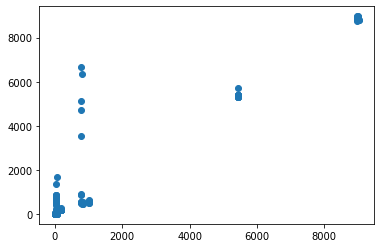

In [22]:
plt.scatter(y_val_hat_svr,y_val)
#plt.scatter(y_pred_val,y_val)

In [23]:
for i in range(y_test.shape[0]):
    print("%10.3f %10.3f"%(y_test_hat_svr[i,0],y_test[i,0]))

    15.888      1.000
    14.109      1.000
  5424.749   5432.800
    16.663    421.800
    44.000    840.400
   811.867   2463.000
    16.026      1.000
    16.663      7.000
    16.754      1.000
    14.109      3.000
    43.624     14.200
   190.115    175.000
    15.888      1.000
    30.395     12.000
   782.158   2449.800
    31.288     19.200
    34.605     19.000
    16.754      1.000
    21.784     12.000
    16.754      1.000
    16.237      1.000
    14.109      2.000
    16.663    218.600
     9.428      1.000
    21.784      1.000
    15.888      5.000
    30.395     33.000
   190.900    176.200
    16.754      1.000
     8.620     19.000
  8991.413   9345.200
    43.624     25.600
    15.215      2.000
   190.900    175.400
    16.663      3.000
    14.109      3.000
    16.754      1.000
    16.237      1.000
    34.605     19.000
    34.605     19.000
    17.525     70.000
    34.311     19.200
    43.624      7.000
    17.525     35.800
    17.525      3.000
    16.754

In [24]:
baseline = np.var(y_val)
mse= mean_squared_error(y_pred_val,y_val)
r2 = 1 - (mse/baseline)
r2

-0.13620373428859867

<div style="background-color:rgb(174, 229, 202);">

**SVR  con targets logarítmicos**

In [67]:
from sklearn.svm import NuSVR
from sklearn.preprocessing import StandardScaler
from time import time
sv_log = NuSVR(C=300, nu=0.3)

scaler_yz_log = StandardScaler()
scaler_yz_log = scaler_yz_log.fit(y_train_log)

y_train_scaled_svr_log = scaler_yz_log.transform(y_train_log)
y_val_scaled_svr_log = scaler_yz_log.transform(y_val_log)
y_test_scaled_svr_log = scaler_yz_log.transform(y_test_log)

t0=time()
print("before train: Init time: {}".format(round(t0,3)))

sv_log.fit(x_train, np.ravel(y_train_scaled_svr_log))
t1=time()
print("after train, finish time: {}".format(round(t1,3)))
print("training time {}",format(round(t1-t0,3)))
y_train_hat_svr_log = scaler_yz_log.inverse_transform(sv_log.predict(x_train).reshape(-1, 1))
y_val_hat_svr_log = scaler_yz_log.inverse_transform(sv_log.predict(x_val).reshape(-1, 1))
y_test_hat_svr_log = scaler_yz_log.inverse_transform(sv_log.predict(x_test).reshape(-1, 1))

#MSE for valid
mse_svr_curr_log = np.sqrt(mean_squared_error(np.exp(y_train_hat_svr_log),y_train))
mse_svr_val_curr_log = np.sqrt(mean_squared_error(np.exp(y_val_hat_svr_log),y_val))
mse_svr_test_curr_log = np.sqrt(mean_squared_error(np.exp(y_test_hat_svr_log),y_test))

scores_train_curr_log = sv_log.score(x_train, y_train_scaled_svr_log)
scores_val_curr_log = sv_log.score(x_val,   y_val_scaled_svr_log)
scores_test_curr_log = sv_log.score(x_test,   y_test_scaled_svr_log)

print("MSE val: {}, MSE train {}, R2 val:{}, R2 train:{}".format(mse_svr_val_curr_log,mse_svr_curr_log,scores_val_curr_log,scores_train_curr_log))
print("MSE test: {}, R2 test:{}".format(mse_svr_test_curr_log, scores_test_curr_log))

before train: Init time: 1567015699.161


/home/daniel/.conda/envs/rhassan/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


after train, finish time: 1567015708.422
training time {} 9.261
MSE val: 842.4352279780106, MSE train 1437.6831084960165, R2 val:0.8841592164182628, R2 train:0.8595052728151176
MSE test: 698.5753271923564, R2 test:0.8689339840619775


In [65]:
for i in range(y_test.shape[0]):
    print("%10.3f %10.3f"%(np.exp(y_test_hat_svr_log[i,0]),y_test[i,0]))

     1.498      1.000
     2.807      1.000
  3824.698   5432.800
     5.994    421.800
    41.064    840.400
   769.493   2463.000
     1.498      1.000
     5.994      7.000
     1.497      1.000
     2.807      3.000
    39.767     14.200
   161.669    175.000
     1.498      1.000
    21.556     12.000
   819.621   2449.800
    26.391     19.200
    28.737     19.000
     1.497      1.000
    18.702     12.000
     1.497      1.000
     1.499      1.000
     2.807      2.000
     5.994    218.600
     1.341      1.000
    18.702      1.000
     1.498      5.000
    21.556     33.000
   161.975    176.200
     1.497      1.000
    25.571     19.000
  6457.336   9345.200
    39.767     25.600
     0.667      2.000
   161.975    175.400
     5.994      3.000
     2.807      3.000
     1.497      1.000
     1.499      1.000
    28.737     19.000
    28.737     19.000
     2.994     70.000
    26.462     19.200
    39.767      7.000
     2.994     35.800
     2.994      3.000
     1.497

<div style="background-color:rgb(174, 229, 202);">

**SVR  con targets logarítmicos**

Los r2_score obtenidos son peores que los que entrega la SVR con los targets sin escala logarítmica.

- MSE train 1437.68
- MSE val: 842.43
- MSE test: 698.57
- R2 train:0.86
- R2 val:0.88
- R2 test:0.87